In [1]:
##### ATOC7500 - chisquared.ipynb - Lecture #3
##### Originally coded by Prof. Kay (University of Colorado Boulder)
##### Last updated: September 9, 2020

##A chi-square test ( Snedecor and Cochran, 1983) can be used to test if the 
##variance of a population is equal to a specified value. This test can be either 
##a two-sided test or a one-sided test. The two-sided version tests against the 
##alternative that the true variance is either less than or greater than the specified value.
##The one-sided version only tests in one direction. 
##The choice of a two-sided or one-sided test is determined by the problem. 

# Import the packages and general set-up
%matplotlib inline  
# this enables plotting within notebook
import matplotlib   # library for plotting
import matplotlib.pyplot as plt # basic plotting; later you will type plt.$COMMAND
import numpy as np # basic math library  you will type np.$STUFF  e.g., np.cos(1)
import scipy.stats as stats # imports stats functions https://docs.scipy.org/doc/scipy/reference/stats.html  
import xarray  ##netcdf manipulation - slick array manipulation

In [2]:
## Read in the data from netcdf files
## These data are global annual mean surface temperatures from the CESM Large Ensemble Project.
fname="TS_timeseries_cesmle_1920_2100.nc"
ds=xarray.open_dataset(fname)
year_transient=ds["year"]
#ds  ## note: uncommenting this line prints information about the data you read in
fname1="TS_timeseries_cesmle_1850.nc"
ds1=xarray.open_dataset(fname1)
gts=ds["gts_ann_allcesmle"]
year=ds["year"]
#gts  ## note: uncommenting this line prints information about the variable gts
gts_1850=ds1["gts_annual"]

In [3]:
#### With the 1850 control we have the opportunity to calculate population statistics with constant forcing.
#### Let's find the population mean and population standard deviation from the 1850 control.  
gts_1850_mean=np.mean(gts_1850).values
gts_1850_std=np.std(gts_1850).values
print("Mean 1850 global mean surface temperature",np.round(gts_1850_mean,2))
print("Standard deviation in 1850 global mean surface temperature:",np.round(gts_1850_std,2))

Mean 1850 global mean surface temperature 287.11
Standard deviation in 1850 global mean surface temperature: 0.1


Mean CESM LE member 1: 290.71
Standard Deviation CESM LE member 1: 1.0
Mean CESM LE member 1 - DETRENDED: 291.0
Standard Deviation CESM LE member 1 - DETRENDED: 0.0


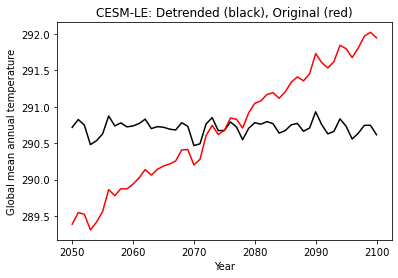

In [4]:
### Next let's calculate future variance
startyear=2050
endyear=2099
nyrs=(endyear-startyear)
gts_mem1=gts.sel(member=1).sel(year=slice(startyear,endyear+1))
year_use=year_transient.sel(year=slice(startyear,endyear+1))
time=np.array(range(len(gts_mem1)))
slope, intercept, r_value, p_value, std_err = stats.linregress(time,gts_mem1-gts_mem1.mean())
gts_mem1_dtrend=gts_mem1-(time*slope+intercept)
## check with a quick plot
plt.plot(year_use,gts_mem1_dtrend,color='black')
plt.plot(year_use,gts_mem1,color='red')
plt.title('CESM-LE: Detrended (black), Original (red)')
plt.ylabel('Global mean annual temperature')
plt.xlabel('Year')

#print(gts_mem1)
gts_mem1_mean=np.mean(gts_mem1).values
gts_mem1_std=np.std(gts_mem1).values
print('Mean CESM LE member 1:',np.round(gts_mem1_mean,2))
print("Standard Deviation CESM LE member 1:",np.round(gts_mem1_std))

## detrended
gts_mem1_mean_dtrend=np.mean(gts_mem1_dtrend).values
gts_mem1_std_dtrend=np.std(gts_mem1_dtrend).values
print('Mean CESM LE member 1 - DETRENDED:',np.round(gts_mem1_mean_dtrend))
print('Standard Deviation CESM LE member 1 - DETRENDED:',np.round(gts_mem1_std_dtrend))

### just use the detrended values for all future calculations
gts_mem1_mean=gts_mem1_mean_dtrend
gts_mem1_std=gts_mem1_std_dtrend

In [5]:
## calculate chi-square to test if sample variance differs from population variance
sample_variance=gts_mem1_std*gts_mem1_std
print('sample_variance:',np.round(sample_variance,2))
population_variance=gts_1850_std*gts_1850_std
print('population_variance:',np.round(population_variance,2))
df=nyrs-1
chi2_cesmle=(df)*(sample_variance)/(population_variance)  ## Barnes Eq. 118
print('chi2_cesmle:',np.round(chi2_cesmle,2))
## Find the critical value of chi2 for two-sided 95% confidence
crit_value_chi2=stats.chi2.ppf(q=1-((1-0.95)/2),df=df)
print('crit_value_chi2:',np.round(crit_value_chi2,2))

#pvalue_crit=1-stats.chi2.cdf(crit_value_chi2,df=df)
#print('pvalue_crit (needs to be less than 0.025 to reject null)',pvalue_crit)
#pvalue_actual=1-stats.chi2.cdf(chi2_cesmle,df=df)
#print('pvalue_actual (needs to be less than 0.025 to reject null)',pvalue_actual)

sample_variance: 0.01
population_variance: 0.01
chi2_cesmle: 41.94
crit_value_chi2: 69.02


In [6]:
## compare with chi2_cesml2 -- if chi2_cesmle > crit_value_chi2
## reject null hypothesis that standard deviation sample = standard deviation population
if  chi2_cesmle > crit_value_chi2:
    print('chi2_cesmle > crit_value_chi2')
    print('reject null hypothesis (H0: standard deviation sample = standard deviation population)')
if chi2_cesmle < crit_value_chi2:
    print('chi2_cesmle < crit_value_chi2')
    print('cannot reject null hypothesis (HO: standard deviation sample = standard deviation population)')

chi2_cesmle < crit_value_chi2
cannot reject null hypothesis (HO: standard deviation sample = standard deviation population)


In [7]:
#### code to make sure I understand how python is calculating values from chi-distribution##
## Find the critical value of chi2 for given probability
## use 0.975 - Check with Hartman ChiSqaure Table page 18, should get 3.247
#df_test=10
## probability distribution function for chi-squared distribution
#crit_value_chi2=stats.chi2.ppf((1-0.975),df_test)
#print('crit_value_chi2:',round(crit_value_chi2,3))
## For a given chi2 value (3.247) -- find the probability
#chi2value=3.247
### print probabilities and pvalues using cdf
#prob=1-stats.chi2.cdf(chi2value,df_test)
#print(round(prob,3))
#pvalue=stats.chi2.cdf(chi2value,df_test)
#print(round(pvalue,3))